[*********************100%***********************]  1 of 1 completed


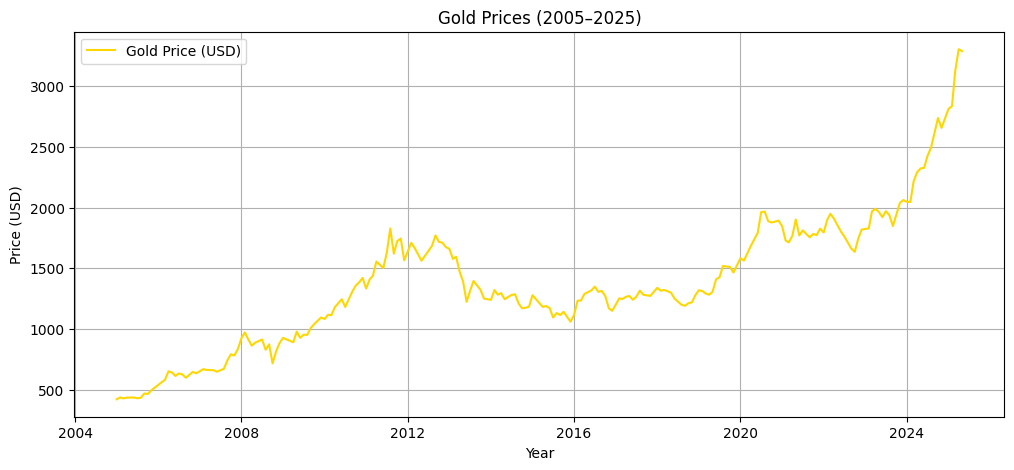

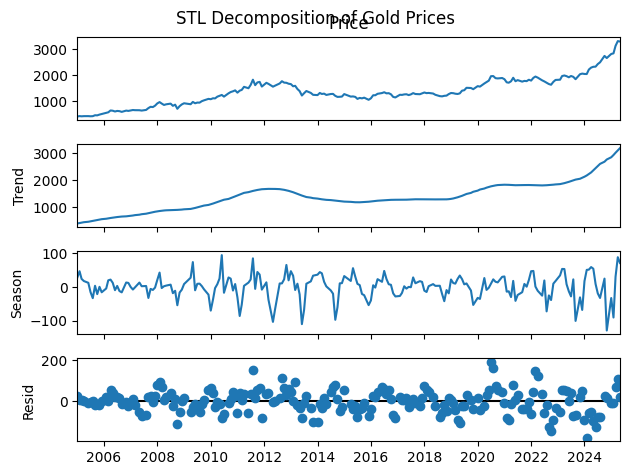

ADF Statistic: 1.535441436691233
p-value: 0.997650368895262


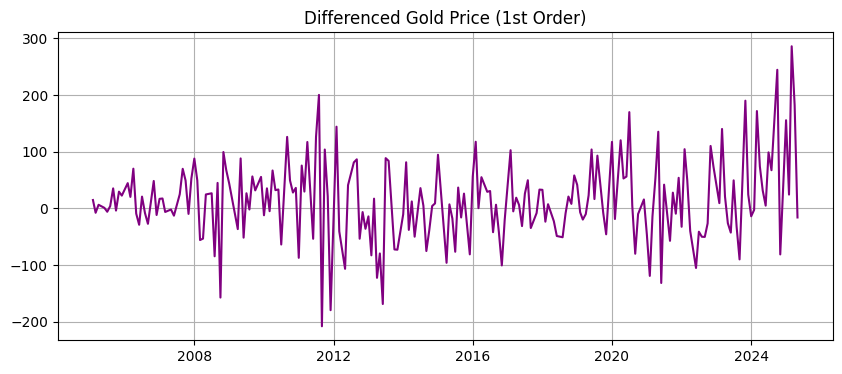


ARIMA Model Summary:

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1192.363
Date:                Thu, 17 Jul 2025   AIC                           2390.727
Time:                        17:22:34   BIC                           2400.754
Sample:                             0   HQIC                          2394.781
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9837      0.066    -14.858      0.000      -1.114      -0.854
ma.L1          0.9654      0.085     11.296      0.000       0.798       1.133
sigma2      5279.5055    428.

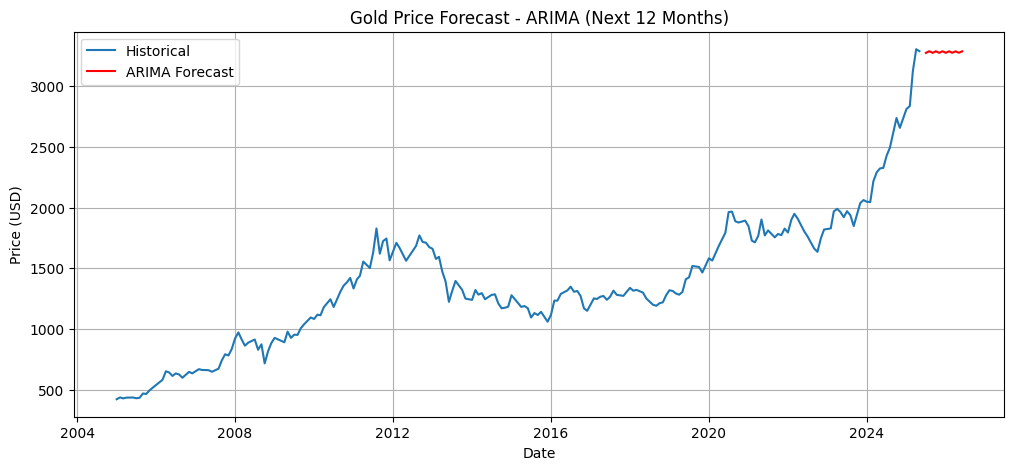


SARIMA Model Summary:

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  210
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1137.283
Date:                            Thu, 17 Jul 2025   AIC                           2284.566
Time:                                    17:22:37   BIC                           2300.982
Sample:                                         0   HQIC                          2291.211
                                            - 210                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      2.969     -0.337      0.736      -6.820       4.820
ma.L1      

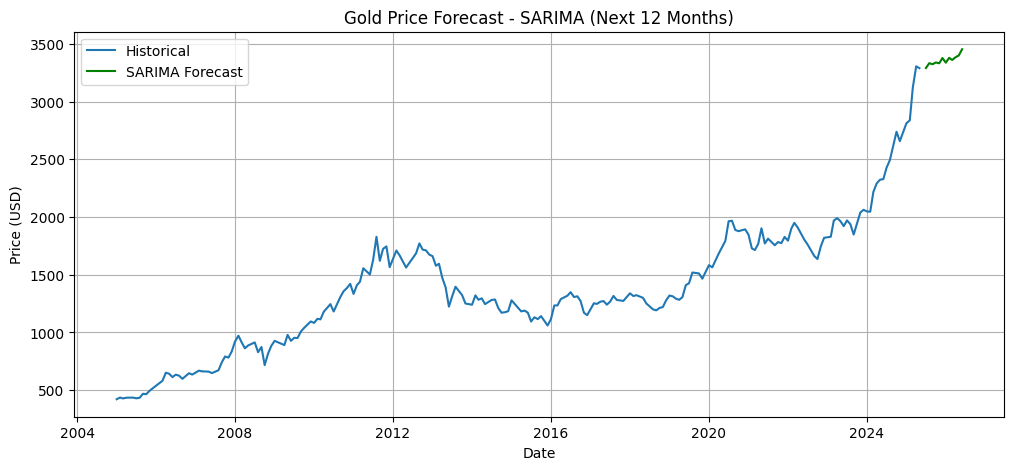

Model Comparison:
ARIMA  - AIC: 2390.73, BIC: 2400.75
SARIMA - AIC: 2284.57, BIC: 2300.98

✅ Selected best model: ARIMA
✅ Saved model to file: arima_gold_model.pkl


In [2]:
# ----------------------------------------------
# Step 1: Install and import necessary libraries
# ----------------------------------------------
!pip install yfinance statsmodels matplotlib pandas --quiet

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------------
# Step 2: Download gold price data (monthly)
# ----------------------------------------------
# GC=F is the Yahoo ticker for gold futures
gold_data = yf.download("GC=F", start="2005-01-01", end="2025-07-01", interval="1mo")

# Keep only the 'Close' prices and remove missing values
gold = gold_data[['Close']].copy()
gold.columns = ['Price']
gold.dropna(inplace=True)

# ----------------------------------------------
# Step 3: Plot the time series
# ----------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(gold, label='Gold Price (USD)', color='gold')
plt.title("Gold Prices (2005–2025)")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

# ----------------------------------------------
# Step 4: STL Decomposition (Trend + Seasonality)
# ----------------------------------------------
stl = STL(gold['Price'], period=12)
result = stl.fit()
result.plot()
plt.suptitle("STL Decomposition of Gold Prices")
plt.show()

# ----------------------------------------------
# Step 5: ADF Test for Stationarity
# ----------------------------------------------
adf_result = adfuller(gold['Price'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
# p > 0.05 → not stationary → we'll use differencing

# ----------------------------------------------
# Step 6: Differencing to Make Series Stationary
# ----------------------------------------------
gold_diff = gold['Price'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(gold_diff, color='purple')
plt.title("Differenced Gold Price (1st Order)")
plt.grid(True)
plt.show()

# ----------------------------------------------
# Step 7: Fit ARIMA Model (Basic)
# ----------------------------------------------
model_arima = ARIMA(gold['Price'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print("\nARIMA Model Summary:\n")
print(model_arima_fit.summary())

# ----------------------------------------------
# Step 8: Forecast using ARIMA (Next 12 Months)
# ----------------------------------------------
forecast_arima = model_arima_fit.forecast(steps=12)
forecast_index = pd.date_range(start=gold.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

plt.figure(figsize=(12, 5))
plt.plot(gold['Price'], label='Historical')
plt.plot(forecast_index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title("Gold Price Forecast - ARIMA (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------
# Step 9: Fit SARIMA Model (Seasonal ARIMA)
# ----------------------------------------------
# SARIMA(p,d,q)(P,D,Q,s)
# We'll use (1,1,1)(1,1,1,12) for monthly seasonality
model_sarima = SARIMAX(gold['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

print("\nSARIMA Model Summary:\n")
print(model_sarima_fit.summary())

# ----------------------------------------------
# Step 10: Forecast using SARIMA (Next 12 Months)
# ----------------------------------------------
forecast_sarima = model_sarima_fit.forecast(steps=12)

plt.figure(figsize=(12, 5))
plt.plot(gold['Price'], label='Historical')
plt.plot(forecast_index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title("Gold Price Forecast - SARIMA (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()










# --------------------------
# Model Comparison: ARIMA vs SARIMA
# --------------------------
print("Model Comparison:")
print(f"ARIMA  - AIC: {model_arima_fit.aic:.2f}, BIC: {model_arima_fit.bic:.2f}")
print(f"SARIMA - AIC: {model_sarima_fit.aic:.2f}, BIC: {model_sarima_fit.bic:.2f}")

# Select better model based on AIC
if model_arima_fit.aic < model_sarima_fit.aic:
    best_model = model_arima_fit
    model_name = "ARIMA"
else:
    best_model = model_sarima_fit
    model_name = "SARIMA"

print(f"\n✅ Selected best model: {model_name}")

# --------------------------
# Save the best model to a pickle file
# --------------------------
import pickle

with open(f"{model_name.lower()}_gold_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved model to file: {model_name.lower()}_gold_model.pkl")

